# Описание данных

Коллега из офиса в Лондоне прислал данные за два года: с 4 января 2015 по 3 января 2017. Изучим динамику числа аренд велосипедов, наличие связи с погодными условиями и выходными, а также объясним аномалии на графике.

* timestamp – дата и время (точность до часа)
* cnt – количество аренд велосипедов за этот час
* t1 – температура, в С
* t2 – температура "ощущается как", в С 
* hum – влажность (%)
* wind_speed – скорость ветра, км/ч
* weather_code – погодные условия:
    - 1 – ясно (SKC)
    - 2 – преимущественно ясно / встречаются отдельные облака (SCT)
    - 3 – облачно / значительные облака (BKN)
    - 4 – пасмурно (OVC)
    - 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    - 10 – дождь с грозой
    - 26 – снегопад 
    - 94 – ледяной туман (да, такое бывает!)
* isholiday – является ли день праздником (1 – праздник, 0 – нет)
* isweekend –  является ли день выходным (1 – выходной, 0 – нет)
* season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

Проверим число наблюдений и столбцов, наличие пропусков. Убедимся, что типы данных были прочитаны правильно. При необходимости – приведем переменные к нужным типам.

In [3]:
# timestamp - столбец с датой, поэтому указываем в parse_dates
# Для дальнейшей работы с данными нужно, чтобы дата была в индексе

rent = pd.read_csv('london.csv', parse_dates=['timestamp'], index_col='timestamp')
rent

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [5]:
# Типы данных
rent.dtypes

cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [6]:
# Пропущенные значения
rent.isna().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Типы данных правильные, пропущенные значения отстуствуют.

Визуализируем число поездок по столбцу timestamp в представленном виде, т.е. число поездок за каждый час.

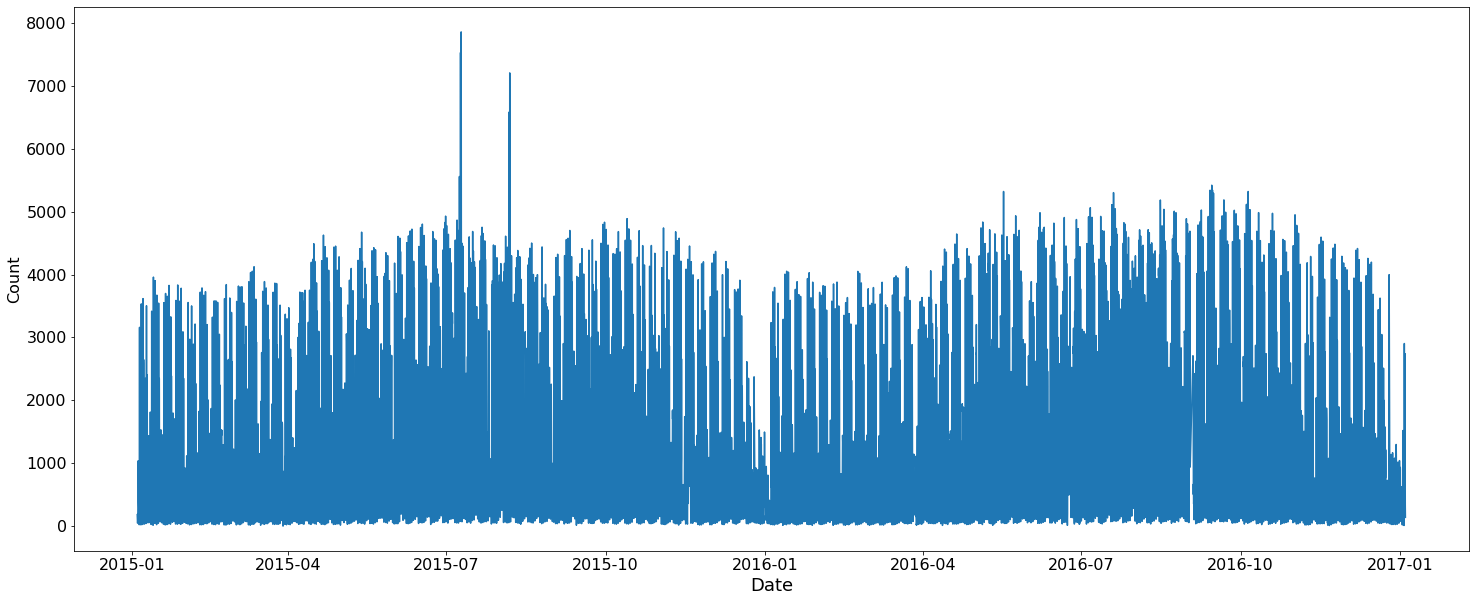

In [8]:
# Настройки графка
plt.figure(figsize=(25,10))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

sns.lineplot(data=rent, x='timestamp', y='cnt')

По полученному графику сложно делать какие-либо выводы, поэтому нужно преобразовать данные. В этом нам поможет resample. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (например, sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. 

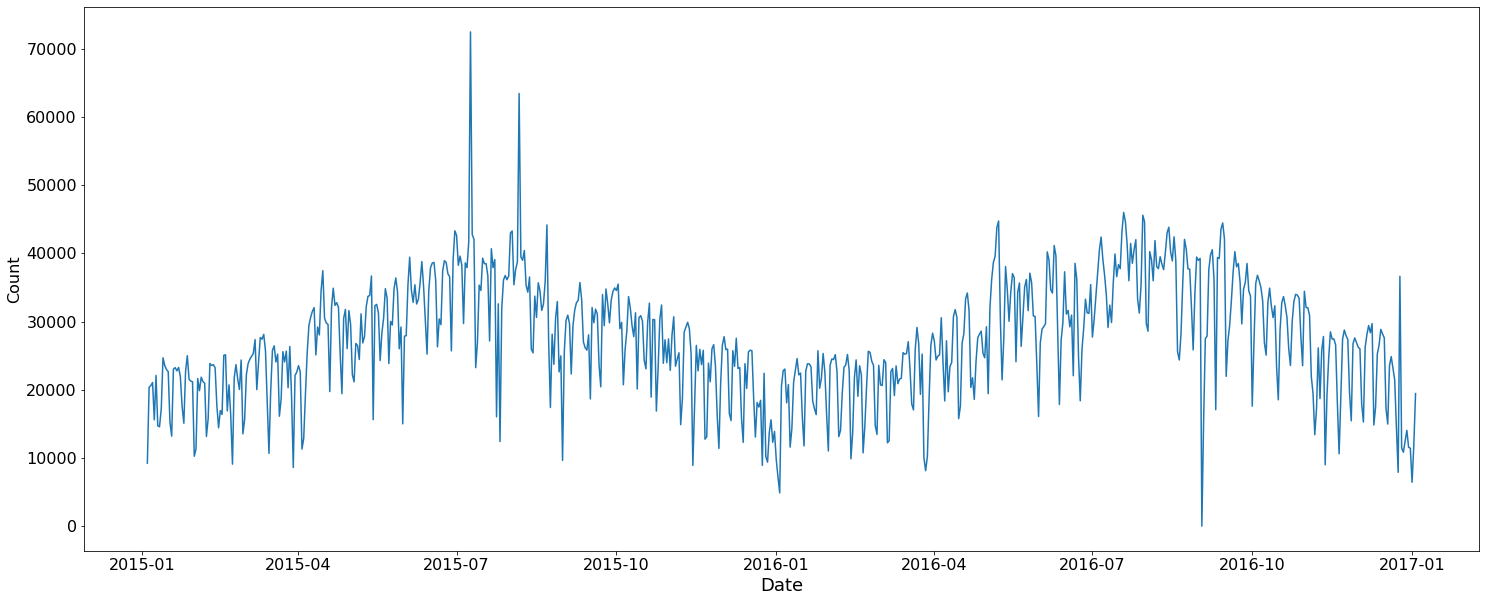

In [9]:
# Аггрегируем данные по дням
rent_by_day = rent.resample(rule='D').agg({'cnt':'sum'})

# Настройки графкиа
plt.figure(figsize=(25,10))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

sns.lineplot(data=rent_by_day, x='timestamp', y='cnt')

По графику можно сделать следующие выводы:
* Встречаются как очень резкие скачки числа аренд, так и падения
* Зимой число аренд меньше, чем летом
* Максимальное число аренд за день составляет более 70 000

Попробуем разобраться, что происходило в дни, когда на графике наблюдаются сильные скачки.
Для этого разделим дальнейшие действия на несколько этапов:

* сначала посчитаем скользящее среднее, чтобы сгладить ряд
* далее – разницу между наблюдаемыми и сглаженными значениями
* определим верхние и нижние границы 99% доверительного интервала 
* найдем причины аномалий!

In [12]:
# Скользящее среднее по 3 наблюдениям
rent_by_day['rolling_mean'] = rent_by_day.cnt.rolling(3).mean()
rent_by_day.head()

,cnt,rolling_mean
timestamp,,
2015-01-04,9234,NaN
2015-01-05,20372,NaN
2015-01-06,20613,16739.666667
2015-01-07,21064,20683.000000
2015-01-08,15601,19092.666667


In [13]:
# Полученное в предыдущем шаге число аренд за 2015-07-09
rent_by_day.loc['2015-07-09'].rolling_mean.astype('int')

50705

Разница между реальным значением и сглаженным достаточно велика. Рассчитаем ее для каждой строки.

In [14]:
# Разница между реальными данными и скользящим средним
rent_by_day['difference'] = rent_by_day.cnt - rent_by_day.rolling_mean
rent_by_day.head()

,cnt,rolling_mean,difference
timestamp,,,
2015-01-04,9234,NaN,NaN
2015-01-05,20372,NaN,NaN
2015-01-06,20613,16739.666667,3873.333333
2015-01-07,21064,20683.000000,381.000000
2015-01-08,15601,19092.666667,-3491.666667


Теперь посмотрим, как изменяется полученная разница и посчитаем 99% интервал. Значения cnt, выходящие за пределы доверительного интервала, будут аномалиями.

In [15]:
# Стандартное отклонение для полученной разницы
np.std(rent_by_day.difference).round(2)

4558.59

In [16]:
# Доверительные интервалы
rent_by_day['lower_bound'] = rent_by_day.rolling_mean - 2.576 * np.std(rent_by_day.difference)
rent_by_day['upper_bound'] = rent_by_day.rolling_mean + 2.576 * np.std(rent_by_day.difference)
rent_by_day.tail()

,cnt,rolling_mean,difference,lower_bound,upper_bound
timestamp,,,,,
2016-12-30,11566,12682.000000,-1116.000000,939.080812,24424.919188
2016-12-31,11424,12347.333333,-923.333333,604.414146,24090.252521
2017-01-01,6421,9803.666667,-3382.666667,-1939.252521,21546.585854
2017-01-02,11823,9889.333333,1933.666667,-1853.585854,21632.252521
2017-01-03,19436,12560.000000,6876.000000,817.080812,24302.919188


In [17]:
# Наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.
anomaly = rent_by_day.query("cnt > upper_bound")
anomaly

,cnt,rolling_mean,difference,lower_bound,upper_bound
timestamp,,,,,
2015-07-09,72504,50705.000000,21799.000000,38962.080812,62447.919188
2015-08-06,63468,46627.333333,16840.666667,34884.414146,58370.252521
2016-09-04,27512,14259.000000,13253.000000,2516.080812,26001.919188
2016-12-25,36653,19650.666667,17002.333333,7907.747479,31393.585854


Исследуем дни с максимальным и минимальным числом аренд и попробуем понять, в чем была причина.

In [19]:
# День, когда число аренд было наибольшим
anomaly.cnt.idxmax()

Timestamp('2015-07-09 00:00:00')

In [20]:
# Посмотрим все записи за 2015-07-09
rent.loc['2015-07-09 00:00:00' : '2015-07-10 00:00:00']

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1.0,0.0,0.0,1.0
2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1.0,0.0,0.0,1.0
2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1.0,0.0,0.0,1.0
2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1.0,0.0,0.0,1.0
2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1.0,0.0,0.0,1.0
2015-07-09 05:00:00,269,13.0,13.0,67.0,17.0,1.0,0.0,0.0,1.0
2015-07-09 06:00:00,1724,13.0,13.0,67.0,16.0,1.0,0.0,0.0,1.0
2015-07-09 07:00:00,5309,13.5,13.5,65.0,17.0,1.0,0.0,0.0,1.0
2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2.0,0.0,0.0,1.0


* Записи присутсвуют за каждый час
* День не является выходным или праздником
* Время года лето, погода - хорошая

Сходу сложно понять, что вызвало такой повышенный спрос на велосипеды. Воспользуемся поиском google, чтобы понять, что происходило в Лондоне 2015-07-09. Оказывается, в этот день была забастовка в метро, что и породило транспортный хаос.

Теперь рассматрим день с наименьшим числом аренд.

In [22]:
# Наблюдения, для которых наблюдаемые значения оказались меньше верхней границы 99% доверительного интервала.
anomaly = rent_by_day.query("cnt < lower_bound")

anomaly.cnt.idxmin()

Timestamp('2016-09-02 00:00:00')

In [23]:
rent.loc['2016-09-02 00:00:00' : '2016-09-03 00:00:00']

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,


В таблице нет никаких записей за этот день -> ошибка при сборе данных.